# Monk1 
Grid Search for Monk1 dataset model selection


In [1]:
from exclusiveAI.components.Validation.HoldOut import parallel_hold_out, hold_out
from exclusiveAI.components.CallBacks import EarlyStoppingCallback
from exclusiveAI.ConfiguratorGen import ConfiguratorGen
from exclusiveAI.Composer import Composer
from tqdm import tqdm
import pandas as pd
import numpy as np
from exclusiveAI.utils import plot_history
import os, json

#### Read Monk1 dataset 

In [2]:
file_path = "MLCup/Data/training_data_split.json"
# Load training and test data from the JSON file
with open(file_path, 'r') as jsonfile:
    data_dict = json.load(jsonfile)

training_data = np.array(data_dict['training_data'])
training_labels = np.array(data_dict['training_labels'])
test_data = np.array(data_dict['test_data'])
test_labels = np.array(data_dict['test_labels'])
train_idx = np.array(data_dict['train_idx'])
test_idx = np.array(data_dict['test_idx'])

In [3]:
# def read_json_files(my_dir_path):
#         data = pd.DataFrame()
#         for file in os.listdir(my_dir_path):
#             if file.endswith('.json'):
#                 with open(os.path.join(my_dir_path, file), 'r') as f:
#                     my_data = []
#                     json_file = json.load(f)
#                     for elem in json_file.values():
#                         for row in elem.values():
#                             my_data.append(row)
#                     data = pd.concat([data,  pd.DataFrame(my_data)], ignore_index=True, axis=0)
#         return data

def read_json_files(my_dir_path):
        data = pd.DataFrame()
        for file in os.listdir(my_dir_path):
            if file.endswith('.json'):
                with open(os.path.join(my_dir_path, file), 'r') as f:
                    my_data = [data['0'] for data in json.load(f).values()]
                    data = pd.concat([data,  pd.DataFrame(my_data)], ignore_index=True, axis=0)
        return data
batch_size = 200
epochs = 1000

final_path = 'MLCup_models_configs10.json'

if not os.path.exists(final_path):
    dir_path = "MLCup/"
    
    all_json_data = read_json_files(dir_path)
    # regularizations = all_json_data['regularization'].unique().tolist()
    # Get the top 3 most common values
    regularizations = all_json_data['regularization'].value_counts().index[:2].tolist()
    
    # learning_rates = all_json_data['learning_rate'].unique().tolist()
    learning_rates = all_json_data['learning_rate'].value_counts().index[:2].tolist()
    # learning_rates = [0.03, 0.05]
    # momentums = all_json_data['momentum'].unique().tolist()
    momentums = all_json_data['momentum'].value_counts().index[:2].tolist()
    # momentums.insert(0,0)
    num_of_layers = all_json_data['num_layers'].unique().tolist()
    num_of_units = set([unit1 for unit in all_json_data['num_of_units'] for unit1 in unit])
    initializers = all_json_data['initializers'].unique().tolist()
    activations = ["sigmoid", 'tanh']

    myConfigurator = ConfiguratorGen(random=False, learning_rates=learning_rates, regularizations=regularizations,
                                     loss_function=['mse'], optimizer=['sgd'],
                                     activation_functions=activations,
                                     number_of_units=num_of_units, number_of_layers=num_of_layers,
                                     momentums=momentums, initializers=initializers,
                                     input_shapes=training_data.shape,
                                     verbose=False, nesterov=True, outputs=3,
                                     callbacks=["earlystopping"], output_activation='linear', show_line=False,
                                     ).get_configs()
    print(len(myConfigurator))
    
    configs=[]
    if __name__ == '__main__':
        configs.append(
            parallel_hold_out(myConfigurator, training=training_data, training_target=training_labels, epochs=epochs, return_models_history=True,
                              batch_size=batch_size, num_models=100, workers=8, number_of_initializations=3, regression=True,
                              ))

        configs = pd.DataFrame(configs)
        # Save as json
        configs.to_json(final_path)
else: 
    with open(final_path, 'r') as f:
        configs = [data['0'] for data in json.load(f).values()]

In [4]:
my_configs = []
# ea = EarlyStoppingCallback(restore_weights=True)
if __name__ == '__main__':
    # for config in configs[1]:
    #     config['callbacks'] = [ea]
    my_configs.append(
        hold_out(configs[1], training=training_data, training_target=training_labels, epochs=epochs, return_models_history=True,
                          batch_size=200, num_models=50, number_of_initializations=2, regression=True,
                          ))

configs=my_configs[0]

Models: 100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


In [9]:
models = []
old_histories = configs[0]
my_configs=configs[1]
with tqdm(total=len(my_configs)) as pbar:
    for old_hist, config in zip(old_histories, my_configs):
        model = Composer(config=config).compose(regression=True)
        model.train(inputs=training_data, input_label=training_labels, epochs=epochs, batch_size=batch_size, name=config['model_name'], disable_line=True)
        test_val = model.evaluate(input=test_data, input_label=test_labels, metrics=['mse', 'mee'])
        models.append((model.get_last()['mse'], np.std(np.array(model.history['mee'])), model.get_last()['mee'], test_val[0], test_val[1], model.curr_epoch, model.best_epoch, np.min(old_hist['mee']),  np.min(old_hist['val_mee']), old_hist['mee'],  old_hist['val_mee'], model.history['mse'], Composer(config=config).compose(), config, config['num_layers'], config['num_of_units'], config['model_name']))
        pbar.update(1)

# Convert the list of tuples to a DataFrame with one column for each element in the tuple
df = pd.DataFrame(models, columns=['Score', 'History_Std', 'Mee', 'Test_Score', 'Test_Mee', 'Trained_Epochs', 'Old_Best_Epochs', 'Old_History_Last', 'Old_History_val_Last', 'Old_History', 'Old_History_val', 'History', 'Model', 'Config', 'Num_Layers', 'Num_of_Units', 'Name'])

100%|██████████| 29/29 [00:29<00:00,  1.01s/it]


In [10]:
# Sort the DataFrame by the first element in the tuple (column 'Value')

df_sorted = df.sort_values(by=['Num_Layers', 'Score', 'Test_Score', 'History_Std'])
# df_sorted = df_sorted[df_sorted['History_Std'] <= 5]
histories = {row[0]: row[1] for row in df_sorted[['Name', 'History']].values}
df_sorted

,Score,History_Std,Mee,Test_Score,Test_Mee,Trained_Epochs,Old_Best_Epochs,Old_History_Last,Old_History_val_Last,Old_History,Old_History_val,History,Model,Config,Num_Layers,Num_of_Units,Name
28,2.201769,4.229910,1.284328,3.384257,1.532921,548,497,1.485865,1.843798,"[42.877155, 39.107445, 37.333794, 34.314934, 3...","[43.36226, 39.07868, 37.35448, 33.90905, 31.64...","[2367.0974, 1555.3016, 1252.5703, 1105.3643, 1...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-06, 'learning_rate': 0.0...",2,"[20, 20]",Model4157
4,2.650721,3.855061,1.460220,3.604769,1.695836,676,625,1.643049,2.098280,"[42.702583, 37.35437, 33.945496, 31.795494, 30...","[43.18318, 37.34655, 33.450665, 30.83106, 29.2...","[2328.0012, 1395.4862, 1141.451, 1074.2188, 10...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-06, 'learning_rate': 0.0...",2,"[20, 20]",Model4121
12,2.710089,4.798756,1.454043,3.926042,1.698890,449,398,1.175663,1.531660,"[43.83614, 37.76204, 34.224964, 32.266167, 31....","[44.241, 37.866127, 33.501556, 31.251959, 29.8...","[2391.621, 1505.5049, 1185.1669, 1101.592, 105...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-08, 'learning_rate': 0.0...",2,"[20, 20]",Model124
20,2.760085,4.152205,1.430795,4.183547,1.718510,536,485,1.671975,2.042480,"[42.38709, 37.11048, 33.14127, 30.719072, 28.5...","[42.858143, 37.154686, 32.423367, 29.640137, 2...","[2342.239, 1411.3418, 1144.627, 1079.0056, 103...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-06, 'learning_rate': 0.0...",2,"[15, 20]",Model4132
0,3.066323,4.221509,1.567558,4.111898,1.766739,433,382,1.326382,1.747158,"[42.124233, 37.90102, 35.33661, 32.348698, 30....","[42.645332, 37.936646, 34.952892, 31.415255, 2...","[2324.211, 1291.9789, 1104.577, 1019.64136, 91...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-06, 'learning_rate': 0.0...",2,"[20, 20]",Model4120
26,3.130227,4.397186,1.602739,4.444358,1.827013,389,338,1.221110,1.574708,"[43.00709, 37.689575, 33.3298, 31.069387, 29.7...","[43.42762, 37.829044, 32.662273, 29.893932, 28...","[2329.319, 1542.5216, 1255.9557, 1053.1599, 86...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-06, 'learning_rate': 0.0...",2,"[20, 20]",Model6137
13,3.134578,3.567091,1.591471,4.595861,1.835617,749,698,1.554205,2.028013,"[42.535194, 38.66365, 37.16691, 34.91598, 32.9...","[43.006004, 38.67431, 37.08943, 34.387547, 31....","[2345.6277, 1589.9061, 1265.5802, 1090.7737, 9...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-08, 'learning_rate': 0.0...",2,"[15, 20]",Model137
3,3.713860,4.176903,1.694459,5.269813,1.920923,403,352,1.095551,1.593730,"[43.291588, 37.285786, 32.954765, 30.540743, 2...","[43.72402, 37.222, 32.09957, 29.123737, 27.467...","[2272.1199, 1514.0663, 1166.0017, 1038.8262, 8...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-06, 'learning_rate': 0.0...",2,"[20, 20]",Model6136
9,3.784438,4.673732,1.705211,5.000817,1.929288,393,342,1.420304,1.904442,"[42.789433, 37.39442, 33.395424, 31.311872, 30...","[43.241753, 37.426067, 32.767254, 30.213972, 2...","[2335.3318, 1475.0123, 1187.6926, 1089.6388, 1...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-08, 'learning_rate': 0.0...",2,"[15, 20]",Model100
16,4.102096,5.743722,1.770294,5.261742,1.984133,503,452,1.430935,1.976228,"[42.89878, 38.616478, 34.30726, 32.09617, 31.2...","[43.34863, 38.972866, 33.76981, 31.040462, 29....","[2317.2073, 1495.834, 1213.079, 1123.8778, 108...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-06, 'learning_rate': 0.0...",2,"[15, 20]",Model4060


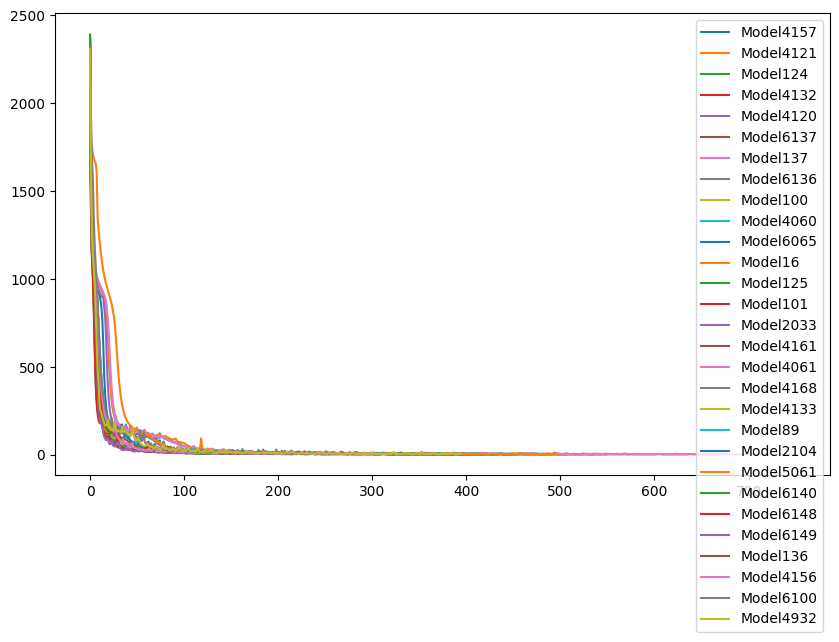

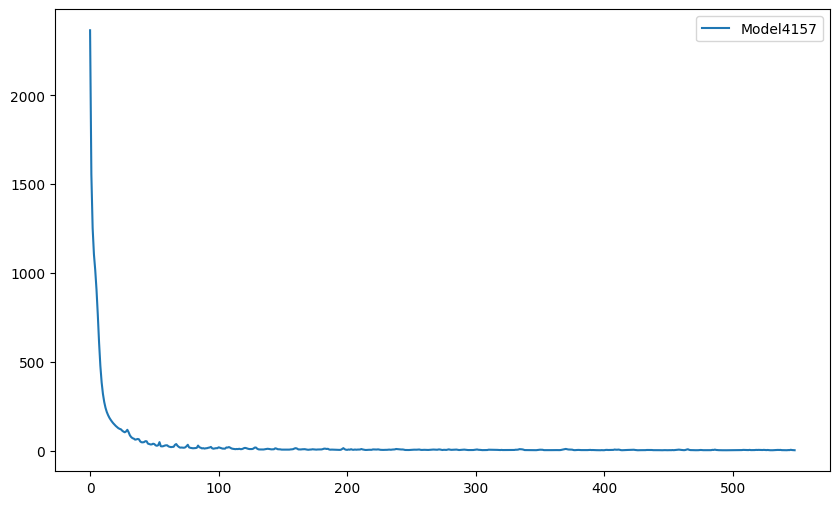

In [11]:
plot_history(histories)
# plot_history({list(histories)[1]: -np.sort(-np.array(list(histories.values())[1]))})
plot_history({list(histories)[0]: list(histories.values())[0]})
# plot_history({list(histories)[1]: list(histories.values())[1]})
# plot_history({"Model286727": histories['Model286727']})

Selected row:
Score                                                            2.650721
History_Std                                                      3.855061
Mee                                                               1.46022
Test_Score                                                       3.604769
Test_Mee                                                         1.695836
Trained_Epochs                                                        676
Old_Best_Epochs                                                       625
Old_History_Last                                                 1.643049
Old_History_val_Last                                              2.09828
Old_History             [42.702583, 37.35437, 33.945496, 31.795494, 30...
Old_History_val         [43.18318, 37.34655, 33.450665, 30.83106, 29.2...
History                 [2328.0012, 1395.4862, 1141.451, 1074.2188, 10...
Model                   <exclusiveAI.components.NeuralNetwork.NeuralNe...
Config                  

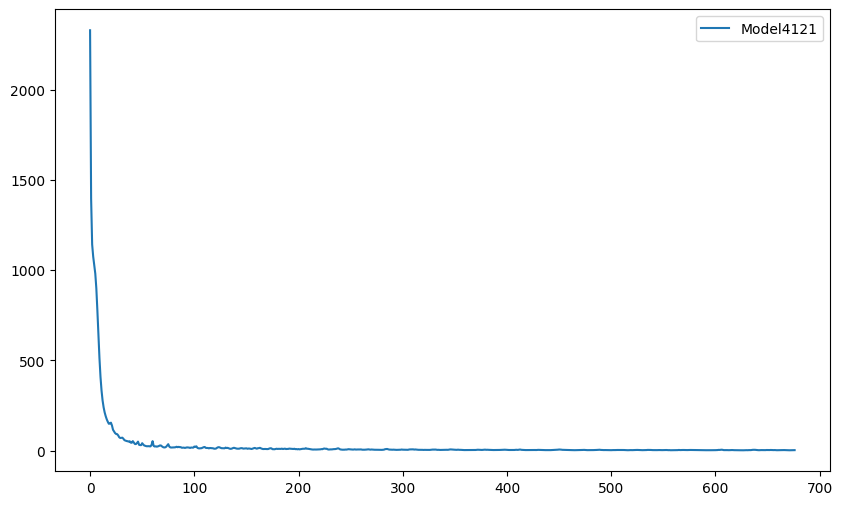

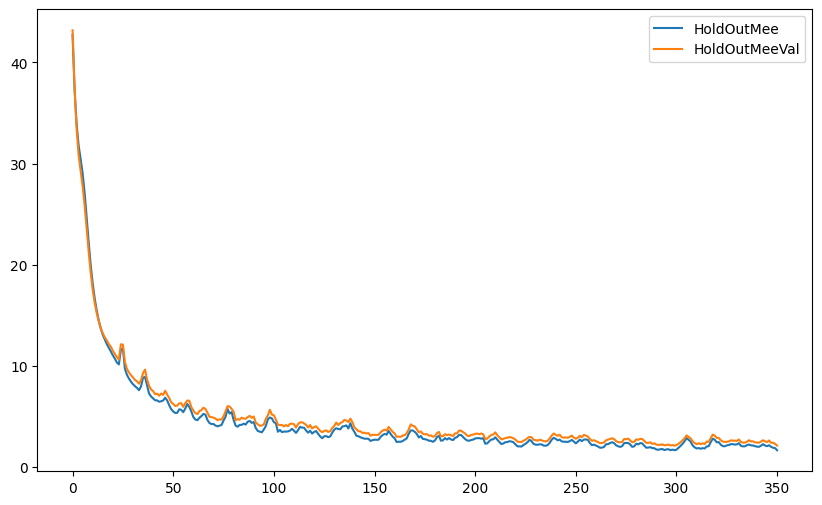

In [12]:
def find_least_difference_row(my_df):
    min_diff = float('inf')
    selected_row = None

    for index, row in my_df.iterrows():
        array = np.array(row['History'])
        differences =  (np.diff(array) / np.mean(array))
        min_consecutive_difference = np.min(differences)

        if min_consecutive_difference < min_diff:
            min_diff = min_consecutive_difference
            selected_row = row

    return selected_row

# Example usage:
result_row = find_least_difference_row(df_sorted)
print("Selected row:")
print(result_row)
plot_history({result_row["Name"]: result_row['History']})
plot_history({'HoldOutMee': result_row['Old_History'], 'HoldOutMeeVal': result_row['Old_History_val']})
